In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

import warnings
warnings.filterwarnings('ignore')

#### Create train/test set for accounts and tweets ####

##### Discussion:
The dataset for accounts and tweets are split into train/test ratio of 2/3 and 1/3. From Milestone#3, we have determined only these features are important.

|Base Account Features|Base Tweets Features|
|:---|:---|
|followers_count   |retweet_count   |
|friends_count   |favorite_count   |
|default_profile   |num_hashtags   | 
||num_urls|
||num_mentions|


In [2]:
account_nlp = pd.read_csv('../../data/users_nlp.csv',keep_default_na=False)
all_accounts =  account_nlp[['followers_count', 'friends_count', 'default_profile', 'user_type']]
train_base_account_df, test_base_account_df = train_test_split(all_accounts, test_size=0.33, random_state=42, stratify=all_accounts['user_type'])
display(train_base_account_df.head(2))
print('train account shape:',train_base_account_df.shape)
print('test account shape:',test_base_account_df.shape)

,followers_count,friends_count,default_profile,user_type
390,1,37,,0
184,12475,12131,,0


train account shape: (295, 4)
test account shape: (146, 4)


In [3]:
combine_df = []
for file_ in ['../../data/tweets_nlp_1.csv','../../data/tweets_nlp_2.csv','../../data/tweets_nlp_3.csv']:
    df = pd.read_csv(file_,index_col=None, header=0,keep_default_na=False)
    combine_df.append(df)
all_tweets = pd.concat(combine_df, axis = 0, ignore_index = True)    
all_tweets_df = all_tweets[['retweet_count', 'favorite_count', 'num_hashtags', 'num_urls', 'num_mentions','user_type']]
train_base_tweets_df, test_base_tweets_df = train_test_split(all_tweets_df, test_size=0.33, random_state=42, stratify=all_tweets_df['user_type'])
display(train_base_tweets_df.head(2))
print('train tweets shape:',train_base_tweets_df.shape)
print('test tweets shape:',test_base_tweets_df.shape)

,retweet_count,favorite_count,num_hashtags,num_urls,num_mentions,user_type
54933,0,0,0,1,0,0
80644,0,0,0,1,0,0


train tweets shape: (80574, 6)
test tweets shape: (39686, 6)


In [16]:
print(all_tweets_df[all_tweets_df.user_type == 0].shape)
print(all_tweets_df[all_tweets_df.user_type == 1].shape)


(70986, 25)
(49274, 25)


#### Base Decision Tree without NLP

First we determine the optimal depth for Decision Tree, then use that depth to train Random Forest. From the plot, the depth > 6 does not improve accuracy. We will pick depth = 6 as best depth. 
The test accurracy is 0.793 and training accuracy 0.795 so nearly match, we can conlude there is no overfit issue. 

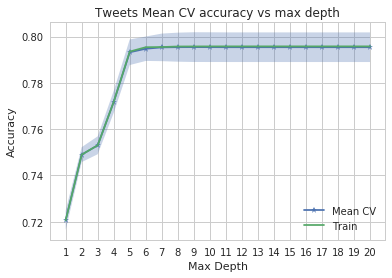

In [4]:
#Perform 5-fold cross validation and store results
X_train, y_train = train_base_tweets_df.drop('user_type',axis=1), train_base_tweets_df['user_type']
X_test, y_test = test_base_tweets_df.drop('user_type',axis=1), test_base_tweets_df['user_type']

depths, train_scores, cvmeans, cvstds, cv_scores = [], [], [], [], []
for depth in range(1,21):
    depths.append(depth)
    dt = DecisionTreeClassifier(max_depth=depth)
    train_scores.append(dt.fit(X_train, y_train).score(X_train, y_train))
    scores = cross_val_score(estimator=dt, X=X_train, y=y_train, cv=5)
    cvmeans.append(scores.mean())
    cvstds.append(scores.std())

#Alter data structure for using internal numpy functions
cvmeans = np.array(cvmeans)
cvstds = np.array(cvstds)
#Plot Means and Shade the +-2 SD Interval
plt.plot(depths, cvmeans, '*-', label="Mean CV")
plt.fill_between(depths, cvmeans - 2*cvstds, cvmeans + 2*cvstds, alpha=0.3)
ylim = plt.ylim()
plt.plot(depths, train_scores, '-+', label="Train")
plt.ylim(ylim)
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.title('Tweets Mean CV accuracy vs max depth')
plt.xticks(depths)
plt.show()

In [5]:
#Choosing the best depth
idx = depths.index(6)
print("Accuracy: Mean={:.3f}, +/- 2 SD: [{:.3f} -- {:.3f}]".format(
    cvmeans[idx], cvmeans[idx] - 2*cvstds[idx], cvmeans[idx] + 2*cvstds[idx]))

Accuracy: Mean=0.795, +/- 2 SD: [0.789 -- 0.800]


In [6]:
#Evaluate performance on Test Set
best_cv_depth = 6
fitted_tree = DecisionTreeClassifier(max_depth=best_cv_depth).fit(X_train, y_train)
best_cv_tree_train_score = fitted_tree.score(X_train, y_train)
best_cv_tree_test_score = fitted_tree.score(X_test, y_test)
print(f"The tree of depth {best_cv_depth} achieved an Accuracy of {best_cv_tree_test_score:.3f} on the test set.")

The tree of depth 6 achieved an Accuracy of 0.793 on the test set.


### Base Random Forest without NLP features

In [7]:
#Fit a Random Forest model
fitted_rf = RandomForestClassifier(n_estimators=6, max_depth=6).fit(X_train,y_train)
random_forest_train_score = fitted_rf.score(X_train, y_train)
random_forest_test_score = fitted_rf.score(X_test, y_test)
print(f"The Random Forest scored {random_forest_train_score:.3f} on the training set.")
print(f"The Random Forest scored {random_forest_test_score:.3f} on the test set.")

The Random Forest scored 0.795 on the training set.
The Random Forest scored 0.794 on the test set.


### Decision Tree with NLP features

In [27]:
all_tweets_df = all_tweets[['retweet_count', 'favorite_count', 'num_hashtags', 'num_urls', 'num_mentions','user_type',
                            'sentiment_negative', 'sentiment_neutral', 'sentiment_positive', 'neg_count', 'pos_count', 'ntl_count', 
                            'sentiment_sum', 'ratio_pos', 'ratio_neg', 'ratio_neu', 'token_count', 'url_token_ratio', 'ant', 
                            'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']]
train_base_tweets_df, test_base_tweets_df = train_test_split(all_tweets_df, test_size=0.33, random_state=42, stratify=all_tweets_df['user_type'])
display(train_base_tweets_df.head(2))
print('train tweets shape:',train_base_tweets_df.shape)
print('test tweets shape:',test_base_tweets_df.shape)

,retweet_count,favorite_count,num_hashtags,num_urls,num_mentions,user_type,sentiment_negative,sentiment_neutral,sentiment_positive,neg_count,pos_count,ntl_count,sentiment_sum,ratio_pos,ratio_neg,ratio_neu,token_count,url_token_ratio,ant,disgust,fear,joy,sadness,surprise,trust
54933,0,0,0,1,0,0,0,0,1,281.0,2416.0,503.0,3200.0,0.755000,0.087813,0.157188,84,0.011905,0,0,0,0,0,0,0
80644,0,0,0,1,0,0,0,1,0,258.0,1331.0,1611.0,3200.0,0.415938,0.080625,0.503437,139,0.007194,0,0,0,0,0,0,0


train tweets shape: (80574, 25)
test tweets shape: (39686, 25)


In [28]:
train_base_tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80574 entries, 54933 to 40769
Data columns (total 25 columns):
retweet_count         80574 non-null int64
favorite_count        80574 non-null int64
num_hashtags          80574 non-null int64
num_urls              80574 non-null int64
num_mentions          80574 non-null int64
user_type             80574 non-null int64
sentiment_negative    80574 non-null int64
sentiment_neutral     80574 non-null int64
sentiment_positive    80574 non-null int64
neg_count             80574 non-null float64
pos_count             80574 non-null float64
ntl_count             80574 non-null float64
sentiment_sum         80574 non-null float64
ratio_pos             80574 non-null float64
ratio_neg             80574 non-null float64
ratio_neu             80574 non-null float64
token_count           80574 non-null int64
url_token_ratio       80574 non-null float64
ant                   80574 non-null int64
disgust               80574 non-null int64
fear       

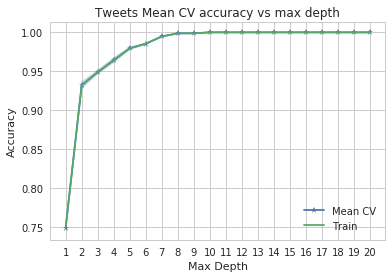

In [29]:
#Perform 5-fold cross validation and store results
X_train, y_train = train_base_tweets_df.drop('user_type',axis=1), train_base_tweets_df['user_type']
X_test, y_test = test_base_tweets_df.drop('user_type',axis=1), test_base_tweets_df['user_type']

depths, train_scores, cvmeans, cvstds, cv_scores = [], [], [], [], []
for depth in range(1,21):
    depths.append(depth)
    dt = DecisionTreeClassifier(max_depth=depth)
    train_scores.append(dt.fit(X_train, y_train).score(X_train, y_train))
    scores = cross_val_score(estimator=dt, X=X_train, y=y_train, cv=5)
    cvmeans.append(scores.mean())
    cvstds.append(scores.std())

#Alter data structure for using internal numpy functions
cvmeans = np.array(cvmeans)
cvstds = np.array(cvstds)
#Plot Means and Shade the +-2 SD Interval
plt.plot(depths, cvmeans, '*-', label="Mean CV")
plt.fill_between(depths, cvmeans - 2*cvstds, cvmeans + 2*cvstds, alpha=0.3)
ylim = plt.ylim()
plt.plot(depths, train_scores, '-+', label="Train")
plt.ylim(ylim)
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.title('Tweets Mean CV accuracy vs max depth')
plt.xticks(depths)
plt.show()

In [30]:
#Choosing the best depth
idx = depths.index(8)
print("Accuracy: Mean={:.3f}, +/- 2 SD: [{:.3f} -- {:.3f}]".format(
    cvmeans[idx], cvmeans[idx] - 2*cvstds[idx], cvmeans[idx] + 2*cvstds[idx]))

Accuracy: Mean=0.999, +/- 2 SD: [0.998 -- 0.999]


In [31]:
#Fit a Random Forest model
fitted_rf = RandomForestClassifier(n_estimators=8, max_depth=8).fit(X_train,y_train)
random_forest_train_score = fitted_rf.score(X_train, y_train)
random_forest_test_score = fitted_rf.score(X_test, y_test)
print(f"The Random Forest scored {random_forest_train_score:.3f} on the training set.")
print(f"The Random Forest scored {random_forest_test_score:.3f} on the test set.")

The Random Forest scored 0.995 on the training set.
The Random Forest scored 0.995 on the test set.
